In [1]:
%load_ext autoreload
%autoreload 2
root_dir = r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/"

In [2]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.dirname(r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/")
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src'))
sys.path.insert(0, os.path.join(project_root, 'utils'))
# project_root = os.path.dirname(r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/")
# print(sys.path)  # Verify the paths are added

In [3]:
from process_yoga_video import process_yoga_video

> Currently, we are getting HOLD phase features after we are sure of holding the pose for 0.5 seconds

SHAPE OF VELOCITY MAGNITUDE: torch.Size([10539, 33])
SHAPE OF SMOOTHED VELOCITY: torch.Size([10539])
Movement detected at frame 1
Hold phase detected at frame 154
HOLD FRAME FEATURES SHAPE: torch.Size([5, 33, 3])
Joint Angles at Frame 183:
0: {'right_shoulder_3d': tensor(174.2156, dtype=torch.float64), 'left_shoulder_3d': tensor(156.9292, dtype=torch.float64), 'right_elbow_3d': tensor(152.8174, dtype=torch.float64), 'left_elbow_3d': tensor(142.5870, dtype=torch.float64), 'right_hip_3d': tensor(171.7372, dtype=torch.float64), 'left_hip_3d': tensor(170.4137, dtype=torch.float64), 'right_knee_3d': tensor(168.4358, dtype=torch.float64), 'left_knee_3d': tensor(171.9270, dtype=torch.float64), 'right_ankle_3d': tensor(121.4553, dtype=torch.float64), 'left_ankle_3d': tensor(126.5456, dtype=torch.float64)}
1: {'right_shoulder_3d': tensor(174.6417, dtype=torch.float64), 'left_shoulder_3d': tensor(156.8934, dtype=torch.float64), 'right_elbow_3d': tensor(152.5409, dtype=torch.float64), 'left_elbow

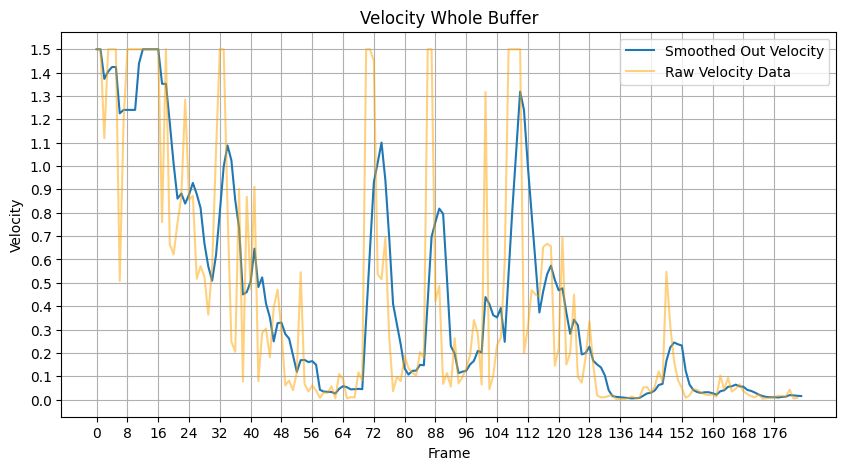

{0: (<PoseState.WAITING: 'waiting'>, 1), 1: (<PoseState.MOVEMENT: 'movement'>, 183), 184: (<PoseState.HOLD: 'hold'>, 0)}


In [4]:
video_path = os.path.join(root_dir, "tiktok_data/mountain/first.mp4")
s = process_yoga_video(video_path)

In [5]:
joint_angle_values = s[1]

In [6]:
joint_configs = {
        # Upper body
        'right_shoulder': {
            'joints': (13, 11, 23),  # right_elbow, right_shoulder, right_hip
            'joint_names': ('right_elbow', 'right_shoulder', 'right_hip'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_shoulder': {
            'joints': (14, 12, 24),  # left_elbow, left_shoulder, left_hip
            'joint_names': ('left_elbow', 'left_shoulder', 'left_hip'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'right_elbow': {
            'joints': (11, 13, 15),  # right_shoulder, right_elbow, right_wrist
            'joint_names': ('right_shoulder', 'right_elbow', 'right_wrist'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_elbow': {
            'joints': (12, 14, 16),  # left_shoulder, left_elbow, left_wrist
            'joint_names': ('left_shoulder', 'left_elbow', 'left_wrist'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        
        # Lower body
        'right_hip': {
            'joints': (11, 23, 25),  # right_shoulder, right_hip, right_knee
            'joint_names': ('right_shoulder', 'right_hip', 'right_knee'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_hip': {
            'joints': (12, 24, 26),  # left_shoulder, left_hip, left_knee
            'joint_names': ('left_shoulder', 'left_hip', 'left_knee'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'right_knee': {
            'joints': (23, 25, 27),  # right_hip, right_knee, right_ankle
            'joint_names': ('right_hip', 'right_knee', 'right_ankle'),
            'planes': ['sagittal', 'transverse', 'frontal']  # Now including transverse
        },
        'left_knee': {
            'joints': (24, 26, 28),  # left_hip, left_knee, left_ankle
            'joint_names': ('left_hip', 'left_knee', 'left_ankle'),
            'planes': ['sagittal', 'transverse', 'frontal']  # Now including transverse
        },
        'right_ankle': {
            'joints': (25, 27, 31),  # right_knee, right_ankle, right_foot_index
            'joint_names': ('right_knee', 'right_ankle', 'right_foot_index'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_ankle': {
            'joints': (26, 28, 32),  # left_knee, left_ankle, left_foot_index
            'joint_names': ('left_knee', 'left_ankle', 'left_foot_index'),
            'planes': ['sagittal', 'transverse', 'frontal']
        }
}

In [7]:
# removes _3d prefix
jav = {}
for k, v in joint_angle_values.items():
    jav[k] = {ik[:-3]: iv for ik, iv in v.items()}

In [8]:
jav[0]
detailed_jav = {}
for k, v in jav[0].items():
    reference_joints = joint_configs[k]['joint_names']
    detailed_jav[k] = (reference_joints, v)
    # print(reference_joints)
    
detailed_jav

{'right_shoulder': (('right_elbow', 'right_shoulder', 'right_hip'),
  tensor(174.2156, dtype=torch.float64)),
 'left_shoulder': (('left_elbow', 'left_shoulder', 'left_hip'),
  tensor(156.9292, dtype=torch.float64)),
 'right_elbow': (('right_shoulder', 'right_elbow', 'right_wrist'),
  tensor(152.8174, dtype=torch.float64)),
 'left_elbow': (('left_shoulder', 'left_elbow', 'left_wrist'),
  tensor(142.5870, dtype=torch.float64)),
 'right_hip': (('right_shoulder', 'right_hip', 'right_knee'),
  tensor(171.7372, dtype=torch.float64)),
 'left_hip': (('left_shoulder', 'left_hip', 'left_knee'),
  tensor(170.4137, dtype=torch.float64)),
 'right_knee': (('right_hip', 'right_knee', 'right_ankle'),
  tensor(168.4358, dtype=torch.float64)),
 'left_knee': (('left_hip', 'left_knee', 'left_ankle'),
  tensor(171.9270, dtype=torch.float64)),
 'right_ankle': (('right_knee', 'right_ankle', 'right_foot_index'),
  tensor(121.4553, dtype=torch.float64)),
 'left_ankle': (('left_knee', 'left_ankle', 'left_foot_i

In [9]:
import torch
formatted_data = {}
for joint, data in detailed_jav.items():
        # Check if the data is a tuple (joints, angle) or just an angle
        if isinstance(data, tuple):
            angle = data[0]
        else:
            angle = data
        
        # Convert tensor to float
        # if isinstance(angle, torch.Tensor):
        #     formatted_data[joint] = float(angle)
        # else:
        #     formatted_data[joint] = float(angle)
        formatted_data[joint] = angle
formatted_data 

{'right_shoulder': ('right_elbow', 'right_shoulder', 'right_hip'),
 'left_shoulder': ('left_elbow', 'left_shoulder', 'left_hip'),
 'right_elbow': ('right_shoulder', 'right_elbow', 'right_wrist'),
 'left_elbow': ('left_shoulder', 'left_elbow', 'left_wrist'),
 'right_hip': ('right_shoulder', 'right_hip', 'right_knee'),
 'left_hip': ('left_shoulder', 'left_hip', 'left_knee'),
 'right_knee': ('right_hip', 'right_knee', 'right_ankle'),
 'left_knee': ('left_hip', 'left_knee', 'left_ankle'),
 'right_ankle': ('right_knee', 'right_ankle', 'right_foot_index'),
 'left_ankle': ('left_knee', 'left_ankle', 'left_foot_index')}

In [10]:
import torch
from typing import Dict, Tuple, List, Any, Union

ACTION_JOINT_MAPPING = {
    'T_pose': ['right_shoulder', 'left_shoulder', 'right_elbow', 'left_elbow'],
    'warrior_pose': ['right_knee', 'left_knee', 'right_hip', 'left_hip', 'right_ankle', 'left_ankle'],
    'tree_pose': ['right_hip', 'left_hip', 'right_knee', 'left_knee', 'right_ankle', 'left_ankle'],
    'mountain': ['right_ankle', 'left_ankle', 'right_knee', 'left_knee', 'right_hip', 'left_hip', 'right_shoulder', 'left_shoulder']
}

TARGET_ANGLES = {
    'T_pose': {
        'right_shoulder': 180.0,
        'left_shoulder': 180.0,
        'right_elbow': 180.0,
        'left_elbow': 180.0
    },
    'warrior_pose': {
        'right_knee': 90.0,  # Front knee bent at 90 degrees
        'left_knee': 170.0, # Back leg relatively straight, slight bend to avoid hyperextension
        'right_hip': 170.0, # Open hip, but not excessively so
        'left_hip': 170.0,
        'right_ankle': 90.0,
        'left_ankle': 90.0
    },
    'mountain': {
        'right_ankle': 130, # Ideally straight, but allow for slight variations
        'left_ankle': 130,
        'right_knee': 175.0, # Not locked, slight bend to prevent hyperextension
        'left_knee': 175.0,
        'right_hip': 180.0,
        'left_hip': 180.0,
        'right_shoulder': 180.0,
        'left_shoulder': 180.0
    }
}

def format_angle_data(angle_data: Dict[str, Union[Tuple, torch.Tensor]]) -> Dict[str, float]:
    """
    Convert the raw angle data into a clean dictionary of float values
    """
    formatted_data = {}
    for joint, data in angle_data.items():
        # Check if the data is a tuple (joints, angle) or just an angle
        if isinstance(data, tuple):
            angle = data[1]
        else:
            angle = data
        
        # Convert tensor to float
        if isinstance(angle, torch.Tensor):
            formatted_data[joint] = float(angle)
        else:
            formatted_data[joint] = float(angle)
    
    return formatted_data

def generate_pose_feedback_prompt(
    user_angles: Dict[str, Any],
    target_angles: Dict[str, Any],
    action_type: str,
    joint_configs: Dict[str, Dict[str, Any]]
) -> str:
    """
    Generate a structured prompt for pose feedback
    
    Parameters:
    - user_angles: Dictionary of current user joint angles
    - target_angles: Dictionary of target joint angles
    - action_type: Type of pose/action being performed
    - joint_configs: Configuration dictionary containing joint relationships
    
    Returns:
    - Formatted prompt string
    """
    # Format the angle data
    # print(user_angles)
    user_angles_clean = format_angle_data(user_angles)
    target_angles_clean = format_angle_data(target_angles)
    
    # print("User Angles Clean:", user_angles_clean)
    # print("Target Angles Clean:", target_angles_clean)
    # Get relevant joints for this action
    relevant_joints = ACTION_JOINT_MAPPING.get(action_type, [])
    # print("Relevant Joints:", relevant_joints) 
    # Build the prompt
    prompt_parts = [
        f"Action: {action_type} Pose\n",
        "Current Joint Analysis:\n"
    ]
    
    # Add joint-specific information
    for joint in relevant_joints:
        if joint in user_angles_clean and joint in target_angles_clean:
            current_angle = user_angles_clean[joint]
            target_angle = target_angles_clean[joint]
            # print(current_angle)
            
            # Get involved body parts from joint_configs
            involved_parts = joint_configs[joint]['joint_names']
            
            prompt_parts.append(
                f"- {joint.replace('_', ' ').title()}:\n"
                f"  Current: {current_angle:.1f}°\n"
                f"  Target: {target_angle:.1f}°\n"
                f"  Involved parts: {', '.join(involved_parts)}\n"
            )
    
    # Add instruction for the language model
    prompt_parts.extend([
        "\nContext:",
        f"- This is a {action_type.replace('_', ' ')} position",
        "- Angles represent the degree between connected body parts",
        "- 180° represents a straight line\n",
        "Task: Based on these angles, provide clear, simple feedback in 20-30 words",
        "focusing on the most important corrections needed for proper form.",
        "Prioritize larger deviations and maintain bilateral symmetry where appropriate.",
        "Don't use numbers simply use words used by a typical yoga coach or a fitness coach, but use simple words."
    ])
    
    return "\n".join(prompt_parts)

In [11]:
prompt = generate_pose_feedback_prompt(detailed_jav, TARGET_ANGLES['mountain'], 'mountain', joint_configs)
print(prompt)

Action: mountain Pose

Current Joint Analysis:

- Right Ankle:
  Current: 121.5°
  Target: 130.0°
  Involved parts: right_knee, right_ankle, right_foot_index

- Left Ankle:
  Current: 126.5°
  Target: 130.0°
  Involved parts: left_knee, left_ankle, left_foot_index

- Right Knee:
  Current: 168.4°
  Target: 175.0°
  Involved parts: right_hip, right_knee, right_ankle

- Left Knee:
  Current: 171.9°
  Target: 175.0°
  Involved parts: left_hip, left_knee, left_ankle

- Right Hip:
  Current: 171.7°
  Target: 180.0°
  Involved parts: right_shoulder, right_hip, right_knee

- Left Hip:
  Current: 170.4°
  Target: 180.0°
  Involved parts: left_shoulder, left_hip, left_knee

- Right Shoulder:
  Current: 174.2°
  Target: 180.0°
  Involved parts: right_elbow, right_shoulder, right_hip

- Left Shoulder:
  Current: 156.9°
  Target: 180.0°
  Involved parts: left_elbow, left_shoulder, left_hip


Context:
- This is a mountain position
- Angles represent the degree between connected body parts
- 180° re

In [13]:
# Use Groq API to prompt Llama 7B model
from groq import Groq
from dotenv import load_dotenv
import os
load_dotenv()
client = Groq(api_key=os.getenv("GROQ_API_KEY"))  

completion = client.chat.completions.create(
    model="llama-3.1-8b-instant",
    messages=[
        {
            "role": "system", 
            "content": "You are a helpful fitness coach providing precise, constructive feedback."
        },
        {
            "role": "user", 
            "content": prompt
        }
    ],
    temperature=1,
    max_completion_tokens=1024,
    top_p=1,
    stream=True,
    stop=None,
)

model_feedback = ""
for chunk in completion:
    content = chunk.choices[0].delta.content or ""
    print(content, end="")
    model_feedback += content

# # Extract the model's feedback
# model_feedback = response.choices[0].message.content.strip()
# print(model_feedback)


For mountain pose, focus on these key adjustments: 

* Engage your legs more, lifting your feet and knees higher. Your ankles and knees should be in line.
* Push the back of your legs into the ground, straightening your hips and knees.
* Lengthen your torso, bringing your shoulders directly above your hips. Engage your shoulder blades.
* Keep both shoulders back and down, level with each other.
* Maintain long, strong neck and spine alignment.
* Press your weight evenly between both feet, grounding your body firmly.

In [14]:
print(model_feedback)

For mountain pose, focus on these key adjustments: 

* Engage your legs more, lifting your feet and knees higher. Your ankles and knees should be in line.
* Push the back of your legs into the ground, straightening your hips and knees.
* Lengthen your torso, bringing your shoulders directly above your hips. Engage your shoulder blades.
* Keep both shoulders back and down, level with each other.
* Maintain long, strong neck and spine alignment.
* Press your weight evenly between both feet, grounding your body firmly.


In [15]:
!pip install soundfile
!pip install munch
!pip install espeakng-loader
!pip3 install phonemizer-fork


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import torch
import os
import sys
import platform
import glob
import warnings
from huggingface_hub import hf_hub_download, list_repo_files
# import espeakng_loader
from phonemizer.backend.espeak.wrapper import EspeakWrapper
from pathlib import Path

# Filter out specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.nn.utils.weight_norm")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.rnn")
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# __all__ = ['list_available_voices', 'build_model', 'load_voice', 'generate_speech', 'load_and_validate_voice']

def get_platform_paths():
    """Get platform-specific paths for espeak-ng"""
    system = platform.system().lower()
    
    if system == "windows":
        lib_path = os.path.join(os.getenv("ProgramFiles"), "eSpeak NG", "libespeak-ng.dll")
        data_path = os.path.join(os.getenv("ProgramFiles"), "eSpeak NG", "espeak-ng-data")
    
    elif system == "darwin":  # macOS
        lib_path = "/opt/homebrew/lib/libespeak-ng.dylib"
        brew_data = "/opt/homebrew/share/espeak-ng-data"
        sys_lib = "/usr/local/lib/libespeak-ng.dylib"
        sys_data = "/usr/local/share/espeak-ng-data"
        lib_path = lib_path if os.path.exists(lib_path) else sys_lib
        data_path = brew_data if os.path.exists(brew_data) else sys_data
    
    else:  # Linux
        data_path = "/usr/lib/x86_64-linux-gnu/espeak-ng-data"
        lib_paths = [
            "/lib/x86_64-linux-gnu/libespeak-ng.so.1",
            "/usr/lib/x86_64-linux-gnu/libespeak-ng.so",
            "/usr/lib/libespeak-ng.so",
            "/usr/lib/x86_64-linux-gnu/libespeak-ng.so.1",
            "/usr/lib/aarch64-linux-gnu/libespeak-ng.so",
            "/usr/lib64/libespeak-ng.so"
        ]
        
        lib_path = None
        for path in lib_paths:
            if os.path.exists(path):
                lib_path = path
                break
        
        if lib_path is None:
            lib_path = lib_paths[0]  # Default for error message
    
    return lib_path, data_path

def setup_espeak():
    """Set up espeak library paths for phonemizer."""
    try:
        lib_path, data_path = get_platform_paths()
        
        if not os.path.exists(lib_path):
            raise FileNotFoundError(f"espeak-ng library not found at {lib_path}")
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"espeak-ng data not found at {data_path}")
            
        EspeakWrapper.set_library(lib_path)
        EspeakWrapper.data_path = data_path
        
        # Configure phonemizer for UTF-8
        os.environ["PHONEMIZER_ESPEAK_LIBRARY"] = lib_path
        os.environ["PHONEMIZER_ESPEAK_PATH"] = data_path
        os.environ["PYTHONIOENCODING"] = "utf-8"
        
        print("espeak-ng library paths set up successfully")
        
    except Exception as e:
        print(f"Error setting up espeak: {e}")
        print("\nPlease ensure espeak-ng is installed:")
        print("- Windows: Download from https://github.com/espeak-ng/espeak-ng/releases")
        print("- macOS: brew install espeak-ng")
        print("- Linux: sudo apt install espeak-ng")
        raise e

c:\Users\aagab\codes\Human_pose\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import os
import sys
from importlib.util import spec_from_file_location, module_from_spec

def import_module_from_path(module_name, module_path):
    """Import a module from file path."""
    try:
        spec = spec_from_file_location(module_name, module_path)
        module = module_from_spec(spec)
        sys.modules[module_name] = module
        spec.loader.exec_module(module)
        return module
    except Exception as e:
        print(f"Error importing module {module_name}: {e}")
        raise e

def build_model(local_folder, device='cpu'):
    """
    Build the Kokoro TTS model for offline usage.
    Args:
        local_folder (str): Path to the folder containing all required files.
        device (str): Device to load the model on ('cpu' or 'cuda').
    Returns:
        The Kokoro TTS model instance.
    """
    try:
        setup_espeak()
        # Path to all required files
        model_path = os.path.join(local_folder, "kokoro-v0_19.pth")
        kokoro_py = os.path.join(local_folder, "kokoro.py")
        models_py = os.path.join(local_folder, "models.py")
        istftnet_py = os.path.join(local_folder, "istftnet.py")
        plbert_py = os.path.join(local_folder, "plbert.py")
        config_json = os.path.join(local_folder, "config.json")

        # Import required modules
        print("Importing plbert module...")
        plbert_module = import_module_from_path("plbert", plbert_py)
        print("Importing istftnet module...")
        istftnet_module = import_module_from_path("istftnet", istftnet_py)
        print("Importing models module...")
        models_module = import_module_from_path("models", models_py)
        print("Importing kokoro module...")
        kokoro_module = import_module_from_path("kokoro", kokoro_py)

        # Test phonemizer (optional; ensure phonemizer is installed)
        from phonemizer import phonemize
        test_phonemes = phonemize("Hello")
        print(f"Phonemizer test successful: 'Hello' -> {test_phonemes}")

        # Build the model
        print("Building model...")
        model = models_module.build_model(model_path, device)
        print(f"Model loaded successfully on {device}")
        return model
    except Exception as e:
        print(f"Error building model: {e}")
        raise e


In [18]:
import os

# Get current working directory
current_dir = os.getcwd()
tts_model_path = os.path.join(current_dir, 'tts_model')
voices_path = os.path.join(tts_model_path, 'voices')
model_path = os.path.join(tts_model_path, 'kokoro-v0_19.pth')
# Ensure model_path exists
if not os.path.exists(model_path):
    print(f"Model file not found at {model_path}")
    model_path = None

model_path

'c:\\Users\\aagab\\codes\\Human_pose\\new_statistical_coach\\scripts\\tts_model\\kokoro-v0_19.pth'

In [19]:
def list_available_voices(voices_path = voices_path):
    try:
        # Ensure voices directory exists
        if not os.path.exists(voices_path):
            print(f"Voices directory does not exist at {voices_path}. Creating directory...")
            os.makedirs(voices_path)
            return []
        # List all files in the voices directory
        voice_files = os.listdir(voices_path)
        voices = [
            os.path.splitext(voice)[0] 
            for voice in voice_files 
            if voice.endswith('.pt') or voice.endswith('.pth')
        ]
        return voices
    except Exception as e:
        print(f"Error listing voices: {e}")
        return []

In [20]:
list_available_voices()

['af',
 'af_bella',
 'af_nicole',
 'af_sarah',
 'af_sky',
 'am_adam',
 'am_michael',
 'bf_emma',
 'bf_isabella',
 'bm_george',
 'bm_lewis']

In [21]:
def load_voice(voice_name: str, device: str):
    """Load a specific voice tensor from the voices directory.
    
    Args:
        voice_name: Name of the voice file to load (without extension)
        device: Device to load the tensor on ('cuda' or 'cpu')
    
    Returns:
        Loaded voice tensor
    """
    voice_file_path = os.path.join(voices_path, f"{voice_name}.pt")
    
    # Check if the voice file exists
    if not os.path.exists(voice_file_path):
        voice_file_path = os.path.join(voices_path, f"{voice_name}.pth")
        
    if not os.path.exists(voice_file_path):
        raise ValueError(f"Voice file for '{voice_name}' not found in {voices_path}")
    
    # Load the voice tensor
    voice_tensor = torch.load(voice_file_path, weights_only=True, map_location=device)
    return voice_tensor

In [22]:
def load_and_validate_voice(voice_name: str = 'af_bella', device: str= 'cpu') -> torch.Tensor:
    """Load and validate the requested voice.
    
    Args:
        voice_name: Name of the voice to load
        device: Device to load the voice on ('cuda' or 'cpu')
        
    Returns:
        Loaded voice tensor
        
    Raises:
        ValueError: If the requested voice doesn't exist
    """
    available_voices = list_available_voices()
    if voice_name not in available_voices:
        raise ValueError(f"Voice '{voice_name}' not found. Available voices: {', '.join(available_voices)}")
    return load_voice(voice_name, device)

In [23]:
load_and_validate_voice()

tensor([[[-0.1823,  0.1385, -0.0695,  ..., -0.6827, -0.2810,  0.6663]],

        [[-0.1823,  0.1385, -0.0695,  ..., -0.6827, -0.2810,  0.6663]],

        [[-0.1823,  0.1385, -0.0695,  ..., -0.6827, -0.2810,  0.6663]],

        ...,

        [[-0.1839,  0.0108, -0.0888,  ..., -0.5113,  0.1009,  0.2138]],

        [[-0.1839,  0.0108, -0.0888,  ..., -0.5113,  0.1009,  0.2138]],

        [[-0.1839,  0.0108, -0.0888,  ..., -0.5113,  0.1009,  0.2138]]])

In [24]:
def generate_speech(model, text, voice=None, lang='a', device='cpu'):
    """Generate speech using the Kokoro model."""
    try:
        repo_id = "hexgrad/Kokoro-82M"
        kokoro_py = hf_hub_download(repo_id=repo_id, filename="kokoro.py")
        kokoro_module = import_module_from_path("kokoro", kokoro_py)
        
        # Generate speech
        audio, phonemes = kokoro_module.generate(model, text, voice, lang=lang)
        
        # Handle phonemes encoding
        if phonemes:
            try:
                # Debug info
                print(f"Debug - Original phonemes type: {type(phonemes)}")
                print(f"Debug - Original phonemes: {repr(phonemes)}")
                
                # Convert to string if it's bytes
                if isinstance(phonemes, bytes):
                    phonemes = phonemes.decode('utf-8', errors='replace')
                # If it's a string, ensure it's valid UTF-8
                elif isinstance(phonemes, str):
                    # Replace problematic characters with their ASCII approximations
                    replacements = {
                        'É™': 'ə',
                        'ÊŠ': 'ʊ',
                        'Ê': 'ʃ',
                        'æ': 'ae'
                    }
                    for old, new in replacements.items():
                        phonemes = phonemes.replace(old, new)
                
                print(f"Debug - Processed phonemes: {repr(phonemes)}")
            except Exception as e:
                print(f"Debug - Encoding error: {str(e)}")
                # Last resort: strip to ASCII
                phonemes = ''.join(c for c in str(phonemes) if ord(c) < 128)
        
        return audio, phonemes
    except Exception as e:
        print(f"Error generating speech: {e}")
        import traceback
        traceback.print_exc()
        return None, None

In [25]:
import soundfile as sf
SAMPLE_RATE = 22050
DEFAULT_LANG ='a'
def get_audio(text:str) -> None:
    try:
        # Set up device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {device}")
        
        # Load model
        print("\nLoading model...")
        # model_path = model_path  # Replace with your local model path
        print(model_path)
        model = build_model(tts_model_path, device)

        # Load voice
        print("\nLoading voice...")
        voice_name = "af_bella"  # Replace with your preferred voice name
        voice = load_and_validate_voice(voice_name, device)

        # Input text for synthesis
        # text = "Hello, this is a test of the Kokoro TTS system."  # Replace with desired text

        print(f"\nGenerating speech for: '{text}'")
        audio, phonemes = generate_speech(model, text, voice, device=device)  # Replace 'en' with desired language

        # Save output audio
        if audio is not None:
            # Display audio inline
            from IPython.display import Audio, display
            display(Audio(audio, rate=SAMPLE_RATE))
            
            # Optional: save to file
            output_path = "output.wav"
            sf.write(output_path, audio, SAMPLE_RATE)
            print(f"\nAudio saved to {output_path}")
            
            if phonemes:
                print(f"Generated phonemes: {phonemes}")
        else:
            print("Error: Failed to generate audio")

    except Exception as e:
        print(f"Error in main: {e}")
        import traceback
        traceback.print_exc()


In [26]:
get_audio(model_feedback)

Using device: cpu

Loading model...
c:\Users\aagab\codes\Human_pose\new_statistical_coach\scripts\tts_model\kokoro-v0_19.pth
espeak-ng library paths set up successfully
Importing plbert module...
Importing istftnet module...
Importing models module...
Importing kokoro module...
Phonemizer test successful: 'Hello' -> həloʊ 
Building model...
Model loaded successfully on cpu

Loading voice...

Generating speech for: 'For mountain pose, focus on these key adjustments: 

* Engage your legs more, lifting your feet and knees higher. Your ankles and knees should be in line.
* Push the back of your legs into the ground, straightening your hips and knees.
* Lengthen your torso, bringing your shoulders directly above your hips. Engage your shoulder blades.
* Keep both shoulders back and down, level with each other.
* Maintain long, strong neck and spine alignment.
* Press your weight evenly between both feet, grounding your body firmly.'
Truncated to 510 tokens
Debug - Original phonemes type: <c


Audio saved to output.wav
Generated phonemes: fɔːɹ mˈaʊntɪn pˈoʊz, fˈoʊkəs ˌɔn ðiːz kˈiː ɐdʒˈʌstmənts: ˈaestɚɹˌɪsk ɛŋɡˈeɪdʒ jʊɹ lˈɛɡz mˈɔːɹ, lˈɪftɪŋ jʊɹ fˈiːt aend nˈiːz hˈaɪɚ. jʊɹ ˈaeŋkəlz aend nˈiːz ʃˌʊd biː ɪn lˈaɪn.ˈaestɚɹˌɪsk pˈʊʃ ðə bˈaek ʌv jʊɹ lˈɛɡz ˌɪntʊ ðə ɡɹˈaʊnd, stɹˈeɪtənɪŋ jʊɹ hˈɪps aend nˈiːz.ˈaestɚɹˌɪsk lˈɛŋθən jʊɹ tˈɔːɹsoʊ, bɹˈɪŋɪŋ jʊɹ ʃˈoʊldɚz dᵻɹˈɛktli əbˌʌv jʊɹ hˈɪps. ɛŋɡˈeɪdʒ jʊɹ ʃˈoʊldɚ blˈeɪdz.ˈaestɚɹˌɪsk kˈiːp bˈoʊθ ʃˈoʊldɚz bˈaek aend dˈaʊn, lˈɛvəl wɪð ˈiːtʃ ˈʌðɚ.ˈaestɚɹˌɪsk meɪntˈeɪn lˈɔŋ, stɹˈɔŋ nˈɛk aend spˈaɪn ɐlˈaɪnmənt.ˈaestɚɹˌɪsk pɹ
